Neste Notebook são abertos dados relativos a imagens de satelite (.nc), conversão desses dados para um formato de dataframe (e divisão desta dataframe em diversas dataframes conforme o dia). Os valores da Temperatura são colocados num formato de Numpy Array (pois queremos que a aplicação do Canny Algorithm seja num Numpy Array). É feita a visualização da imagem relativa à SST para cada dia duma forma despixilizada (contour) e aplicado o canny a esta imagem. 

Para concluir o Canny é aplicado no Numpy array dos valores da temperatura

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import cv2
import datetime
import xarray as xr
import os

%matplotlib inline

#### Importação dos dados de Atlantic-Iberian Biscay Irish- Ocean Physics Reanalysis

Através da command line eu importei uma base de dados relativa aos ultimos 10 dias dos valores de SST de um dado programa do Copernicus. Trata-se de um ficheiro .nc (netCDF)

No entanto no futuro eu vou querer que o meu programa faça download diretamente dos dados num python script

In [10]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [11]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [12]:
nc_path = os.path.join(data_folder, "IBI-10days.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [13]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CMEMS IBI-MFC
    institution: Puertos del Estado (PdE) - Mercator-Ocean (MO)
    references: http://marine.copernicus.eu
    title: CMEMS IBI REANALYSIS: DAILY PHYSICAL PRODUCTS 
    easting: longitude
    northing: latitude
    domain_name: IBI12
    FROM_ORIGINAL_FILE__field_type: mean
    field_date: 20191224
    FROM_ORIGINAL_FILE__longitude_min: -19.f
    FROM_ORIGINAL_FILE__longitude_max: 5.f
    FROM_ORIGINAL_FILE__latitude_min: 26.f
    FROM_ORIGINAL_FILE__latitude_max: 56.f
    z_min: 0.50576f
    z_max: 5698.061f
    contact: mailto: servicedesk.cmems@mercator-ocean.eu
    bulletin_date: 2020-12-01
    bulletin_type: Reanalysis
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    comment: 
    history: Data extracted from dataset http://localhost:8080/thredds/dodsC/cmems_mod_ibi_phy_my_0.083deg-3D_P1D-m
    dimensions(sizes): time(11),

In [14]:
#Converter o ficheiro netCDF para uma dataframe
datadf = data.to_dataframe()
datadf2 = datadf.reset_index()

In [15]:
datadf2 = datadf2.drop(['depth'], axis=1)
datadf2    #os dados .nc estão agora no formato de uma dataframe

,latitude,longitude,time,thetao
0,35.0,-19.0,2019-12-14 12:00:00,19.723000
1,35.0,-19.0,2019-12-15 12:00:00,19.723000
2,35.0,-19.0,2019-12-16 12:00:00,19.641001
3,35.0,-19.0,2019-12-17 12:00:00,19.566000
4,35.0,-19.0,2019-12-18 12:00:00,19.621000
...,...,...,...,...
224934,45.0,-5.0,2019-12-20 12:00:00,13.619000
224935,45.0,-5.0,2019-12-21 12:00:00,13.559000
224936,45.0,-5.0,2019-12-22 12:00:00,13.458000
224937,45.0,-5.0,2019-12-23 12:00:00,13.400000


In [16]:
datadf2 = datadf2[['time', 'latitude', 'longitude', 'thetao']]    #reorganizar as colunas da dataframe
datadf2

,time,latitude,longitude,thetao
0,2019-12-14 12:00:00,35.0,-19.0,19.723000
1,2019-12-15 12:00:00,35.0,-19.0,19.723000
2,2019-12-16 12:00:00,35.0,-19.0,19.641001
3,2019-12-17 12:00:00,35.0,-19.0,19.566000
4,2019-12-18 12:00:00,35.0,-19.0,19.621000
...,...,...,...,...
224934,2019-12-20 12:00:00,45.0,-5.0,13.619000
224935,2019-12-21 12:00:00,45.0,-5.0,13.559000
224936,2019-12-22 12:00:00,45.0,-5.0,13.458000
224937,2019-12-23 12:00:00,45.0,-5.0,13.400000


In [17]:
#Para analisarmos os dados relativos ao dia 2019-12-14
dia14 = datadf2[datadf2['time'] == '2019-12-14 12:00:00']
dia14

,time,latitude,longitude,thetao
0,2019-12-14 12:00:00,35.0,-19.000000,19.723000
11,2019-12-14 12:00:00,35.0,-18.916666,19.684000
22,2019-12-14 12:00:00,35.0,-18.833334,19.672001
33,2019-12-14 12:00:00,35.0,-18.750000,19.542999
44,2019-12-14 12:00:00,35.0,-18.666666,19.406000
...,...,...,...,...
224884,2019-12-14 12:00:00,45.0,-5.333334,13.456000
224895,2019-12-14 12:00:00,45.0,-5.250000,13.590000
224906,2019-12-14 12:00:00,45.0,-5.166667,13.691000
224917,2019-12-14 12:00:00,45.0,-5.083334,13.704000


#### Código para que dada uma dataframe, esta seja dividida em várias dataframes consoante a data

Os dados que eu vou extrair do satelite serão referentes a vários dias diferentes portanto para facilitar o posterior processamento dos dados, esta função vai me permitir dividir a dataframe original em diversas dataframes conforme a data

In [18]:
datadf2

,time,latitude,longitude,thetao
0,2019-12-14 12:00:00,35.0,-19.0,19.723000
1,2019-12-15 12:00:00,35.0,-19.0,19.723000
2,2019-12-16 12:00:00,35.0,-19.0,19.641001
3,2019-12-17 12:00:00,35.0,-19.0,19.566000
4,2019-12-18 12:00:00,35.0,-19.0,19.621000
...,...,...,...,...
224934,2019-12-20 12:00:00,45.0,-5.0,13.619000
224935,2019-12-21 12:00:00,45.0,-5.0,13.559000
224936,2019-12-22 12:00:00,45.0,-5.0,13.458000
224937,2019-12-23 12:00:00,45.0,-5.0,13.400000


In [19]:
#converter a coluna time para string (pode simplificar)
datadf2['time']=datadf2['time'].astype(str)

In [20]:
#Criar uma lista com as diferentes datas
unique_dates = datadf2['time'].unique()
list_dates = list(unique_dates)
list_dates

['2019-12-14 12:00:00',
 '2019-12-15 12:00:00',
 '2019-12-16 12:00:00',
 '2019-12-17 12:00:00',
 '2019-12-18 12:00:00',
 '2019-12-19 12:00:00',
 '2019-12-20 12:00:00',
 '2019-12-21 12:00:00',
 '2019-12-22 12:00:00',
 '2019-12-23 12:00:00',
 '2019-12-24 12:00:00']

In [21]:
n_unique = datadf2['time'].nunique()
n_unique    #nº de datas diferentes que há na dataframe

11

In [22]:
splits = list(datadf2.groupby("time"))   # divide a dataframe de acordo com a coluna 'time' e agrupa a informação numa lista

In [23]:
splits[1][0]

'2019-12-15 12:00:00'

In [24]:
d = {}
for i in range(n_unique):
    for time in list_dates:
        d[time] = pd.DataFrame(splits[i][1])

In [25]:
d

{'2019-12-14 12:00:00':                        time  latitude  longitude     thetao
 10      2019-12-24 12:00:00      35.0 -19.000000  19.176001
 21      2019-12-24 12:00:00      35.0 -18.916666  19.051001
 32      2019-12-24 12:00:00      35.0 -18.833334  19.094002
 43      2019-12-24 12:00:00      35.0 -18.750000  19.167999
 54      2019-12-24 12:00:00      35.0 -18.666666  19.235001
 ...                     ...       ...        ...        ...
 224894  2019-12-24 12:00:00      45.0  -5.333334  12.736000
 224905  2019-12-24 12:00:00      45.0  -5.250000  12.770000
 224916  2019-12-24 12:00:00      45.0  -5.166667  13.017000
 224927  2019-12-24 12:00:00      45.0  -5.083334  13.291000
 224938  2019-12-24 12:00:00      45.0  -5.000000  13.390000
 
 [20449 rows x 4 columns],
 '2019-12-15 12:00:00':                        time  latitude  longitude     thetao
 10      2019-12-24 12:00:00      35.0 -19.000000  19.176001
 21      2019-12-24 12:00:00      35.0 -18.916666  19.051001
 32      2

In [26]:
for key in d.keys():
    d[key] = datadf2[:][datadf2.time == key]

In [27]:
d['2019-12-18 12:00:00']  

,time,latitude,longitude,thetao
4,2019-12-18 12:00:00,35.0,-19.000000,19.621000
15,2019-12-18 12:00:00,35.0,-18.916666,19.542999
26,2019-12-18 12:00:00,35.0,-18.833334,19.492001
37,2019-12-18 12:00:00,35.0,-18.750000,19.566000
48,2019-12-18 12:00:00,35.0,-18.666666,19.628000
...,...,...,...,...
224888,2019-12-18 12:00:00,45.0,-5.333334,13.279000
224899,2019-12-18 12:00:00,45.0,-5.250000,13.458000
224910,2019-12-18 12:00:00,45.0,-5.166667,13.593000
224921,2019-12-18 12:00:00,45.0,-5.083334,13.654000


In [28]:
d['2019-12-18 12:00:00'].info()    #trata-se duma dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20449 entries, 4 to 224932
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       20449 non-null  object 
 1   latitude   20449 non-null  float64
 2   longitude  20449 non-null  float64
 3   thetao     16377 non-null  float32
dtypes: float32(1), float64(2), object(1)
memory usage: 718.9+ KB


#### Plot do Mapa da SST para o dia 14 despixilizado

In [29]:
dia14 = dia14.drop(['time'], axis=1)
dia14

,latitude,longitude,thetao
0,35.0,-19.000000,19.723000
11,35.0,-18.916666,19.684000
22,35.0,-18.833334,19.672001
33,35.0,-18.750000,19.542999
44,35.0,-18.666666,19.406000
...,...,...,...
224884,45.0,-5.333334,13.456000
224895,45.0,-5.250000,13.590000
224906,45.0,-5.166667,13.691000
224917,45.0,-5.083334,13.704000


In [30]:
Temp = dia14.pivot_table(index='longitude', columns='latitude', values='thetao').T.values

long_unique = np.sort(dia14.longitude.unique())
lat_unique = np.sort(dia14.latitude.unique())
X, Y = np.meshgrid(long_unique, lat_unique)

In [31]:
Temp.shape #por este Temp dentro do Canny

(121, 169)

In [32]:
Temp_14 = pd.DataFrame(Temp).round(5)
Temp_14

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,19.723000,19.684000,19.672001,19.542999,19.406,19.572001,19.731001,19.780001,19.929001,19.799999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19.781000,19.785000,19.770000,19.558001,19.396,19.563999,19.747000,19.862000,19.878000,19.753000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19.858999,19.858999,19.813999,19.582001,19.480,19.667000,19.877001,19.982000,19.879000,19.783001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19.934000,19.898001,19.837000,19.617001,19.612,19.851000,20.055000,20.097000,19.952000,19.830000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.974001,19.910999,19.858999,19.704000,19.788,20.061001,20.225000,20.139999,19.941999,19.813000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,12.911000,12.998000,13.098000,13.109000,13.128,13.176000,13.246000,13.320000,13.409000,13.507000,...,13.172,13.278,13.438,13.580,13.632,13.619,13.637,13.736,13.900,14.007
117,12.871000,12.992000,13.023000,13.039000,13.074,13.133000,13.219000,13.318000,13.399000,13.445000,...,13.106,13.214,13.391,13.574,13.664,13.701,13.777,13.908,13.993,13.883
118,12.828000,12.898000,12.883000,12.863000,12.898,13.000000,13.161000,13.324000,13.408000,13.419000,...,13.042,13.146,13.328,13.532,13.657,13.728,13.815,13.899,13.862,13.629
119,12.715000,12.742000,12.699000,12.645000,12.672,12.825000,13.076000,13.293000,13.382000,13.414000,...,12.995,13.083,13.231,13.415,13.558,13.657,13.751,13.811,13.742,13.595


/tmp/ipykernel_7362/3721560661.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')
/tmp/ipykernel_7362/3721560661.py:21: UserWarning: No contour levels were found within the data range.
  cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)


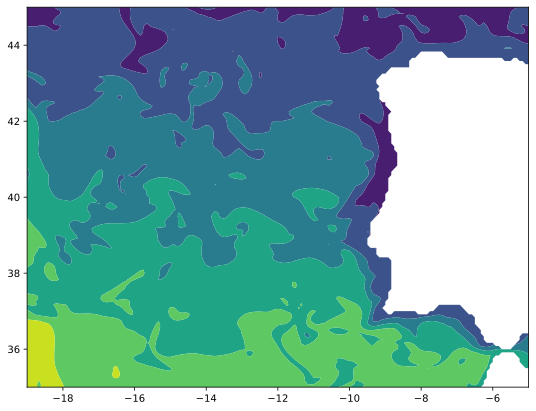

In [121]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = 9,7 # sets plot size
fig = plt.figure()
ax = fig.add_subplot(111)

# Define levels in z-axis where we want lines to appear
levels = np.array([-0.4,-0.2,0,0.2,0.4])   #como os valores estão super baixos não aparece as linhas a separarem valores no mapa   
#levels = np.array([13, 14, 15, 16, 17, 18, 19, 20])  #permite definir no mapa linhas que separam zonas de diferentes temperaturas

# Generate a color mapping of the levels we've specified
import matplotlib.cm as cm # matplotlib's color map library
cpf = ax.contourf(X,Y,Temp, len(levels), cmap=cm.viridis)

# Set all level lines to black
line_colors = ['black' for l in cpf.levels]     

# Make plot and customize axes
cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)
ax.clabel(cp, fontsize=10, colors=line_colors);
#plt.colorbar()
#plt.axis('off')         #Para remover da imagem os labels com a longitude e latitude
#plt.title('SST Map 14 December 2019')


images_folder = os.path.join(current_path, "../images")
plt.savefig(os.path.join(images_folder, "Contour_SST_14.png"))

#### Transformar as coordenadas (longitude e latitude) numa tupple de Pixels (x,y)

In [35]:
#Criar 2 novas colunas X e Y que sejam os pixels correspondentes

lons = dia14["longitude"].astype("float32").unique()
lats = dia14["latitude"].astype("float32").unique()
lons.sort()
lats.sort()
def get_pixels(lons, lats):
    pixels = {}
    for x, lon in enumerate(lons):
        for y, lat in enumerate(lats):
            pixels[(lon, lat)] = (x, y)
    return pixels
def get_x(lon, lat, pixels):
    return pixels[(lon, lat)][0]
def get_y(lon, lat, pixels):
    return pixels[(lon, lat)][1]
pixels = get_pixels(lons, lats)
dia14["x"] = dia14.apply(lambda row: get_x(row["longitude"], row["latitude"], pixels), axis=1)
dia14["y"] = dia14.apply(lambda row: get_y(row["longitude"], row["latitude"], pixels), axis=1)

In [36]:
#Converter as colunas x e y para uma nova coluna no formato de tupple
dia14['Pixels'] = dia14[['x', 'y']].apply(tuple, axis=1)

In [37]:
dia14

,latitude,longitude,thetao,x,y,Pixels
0,35.0,-19.000000,19.723000,0,0,"(0, 0)"
11,35.0,-18.916666,19.684000,1,0,"(1, 0)"
22,35.0,-18.833334,19.672001,2,0,"(2, 0)"
33,35.0,-18.750000,19.542999,3,0,"(3, 0)"
44,35.0,-18.666666,19.406000,4,0,"(4, 0)"
...,...,...,...,...,...,...
224884,45.0,-5.333334,13.456000,164,120,"(164, 120)"
224895,45.0,-5.250000,13.590000,165,120,"(165, 120)"
224906,45.0,-5.166667,13.691000,166,120,"(166, 120)"
224917,45.0,-5.083334,13.704000,167,120,"(167, 120)"


### Aplicar Canny Edge Detector a imagem (.png) do dia 14 obtida através do Seaborn

No entanto o meu objectivo não é aplicar o Canny edge detector a imagens (.png), pois ao gravar a imagem eu perco as dimensões verdadeiras da matriz da Temperatura (a imagem fica nomeadamente com 3 dimensões (RGB))

O objetivo é aplicar o Canny a um numpy array que é uma representação dessa imagem.

In [38]:
contour_SST_14 = cv2.imread(os.path.join(images_folder, "Contour_SST_14.png"))
contour_SST_14

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [39]:
contour_SST_14.shape

(504, 648, 3)

In [40]:
x = os.path.join(images_folder, "Contour_SST_14.png")
x

'/home/luisfigueiredo/JUNO/notebooks/../images/Contour_SST_14.png'

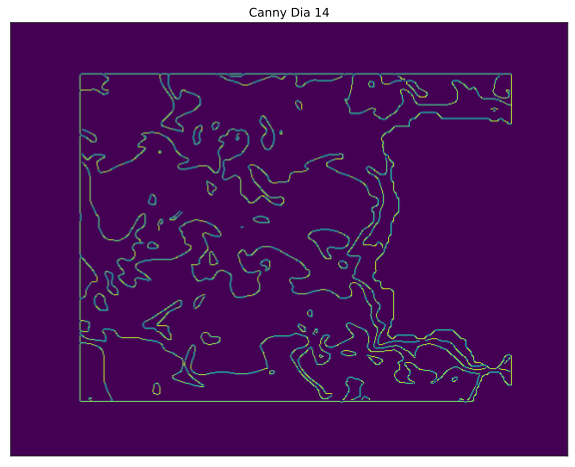

In [41]:
canny = cv2.Canny(contour_SST_14, 100, 180, L2gradient=False, apertureSize=3)
#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. L2gradient is of boolean type. Its default value is False

plt.rcParams["figure.figsize"] = (10,8)

plt.imshow(canny)    #'gray'-> parametro para por a preto e branco
plt.title('Canny Dia 14')
plt.xticks([])
plt.yticks([])
    
plt.show()
#Aplicação do Canny diretamente à imagem previamente guardada

### Aplicar o Canny Algorithm ao numpy array 

Agora vamos aplicar o Canny algorithm no numpy de dimensoes (121, 169) que representa os valores de temperatura

In [ ]:
canny = cv2.Canny(Temp, 100, 200)

#Eu quero fazer um Canny não da imagem que gravei mas da matriz que dá origem a essa imagem 
#Pq quando eu converto para imagem (.png) as dimensões fodem-se todas

#Verificar se o canny aceita Null values e se tenho de converter os valores de temperatura para uma escala entre 0 e 255

# Dá erro pq o Numpy Temp tem de ser do tipo uint8. CV_8U is just an alias for the datatype uint8.

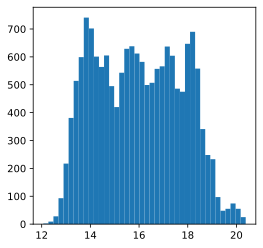

In [45]:
plt.hist(Temp.flatten(), bins=40);
plt.rcParams["figure.figsize"] = 4,4

#### --------------------------------------------------------------------------------------------------------------
#### Usar um array com o formato uint8 (Valores na gama normal entre 0 e 20)
#### --------------------------------------------------------------------------------------------------------------

In [46]:
Temp_aux = Temp.copy() #criar um numpy auxiliar que é uma cópia do numpy Temp
Temp_aux

array([[19.723   , 19.684   , 19.672   , ...,       nan,       nan,
              nan],
       [19.781   , 19.785   , 19.77    , ...,       nan,       nan,
              nan],
       [19.859001, 19.859001, 19.814   , ...,       nan,       nan,
              nan],
       ...,
       [12.828   , 12.898001, 12.883   , ..., 13.899   , 13.862   ,
        13.629   ],
       [12.715   , 12.742001, 12.699   , ..., 13.811   , 13.742001,
        13.595   ],
       [12.723   , 12.664   , 12.633   , ..., 13.691   , 13.704   ,
        13.699   ]], dtype=float32)

In [47]:
Temp_aux.shape

(121, 169)

In [48]:
#Converter o array para o formato uint8
Temp_aux = Temp_aux.astype(np.uint8)

In [49]:
Temp_aux

array([[19, 19, 19, ...,  0,  0,  0],
       [19, 19, 19, ...,  0,  0,  0],
       [19, 19, 19, ...,  0,  0,  0],
       ...,
       [12, 12, 12, ..., 13, 13, 13],
       [12, 12, 12, ..., 13, 13, 13],
       [12, 12, 12, ..., 13, 13, 13]], dtype=uint8)

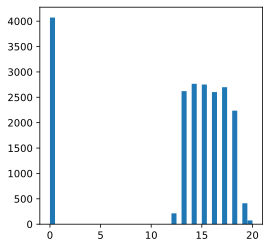

In [50]:
#Para verificarmos que os valores estão de facto entre 0 e 20
plt.hist(Temp_aux.flatten(), bins=40);
plt.rcParams["figure.figsize"] = 4, 4

In [51]:
Temp_aux = np.flipud(Temp_aux)   #flipud -> Reverse the order of elements along axis 0 (up/down).
Temp_aux

array([[12, 12, 12, ..., 13, 13, 13],
       [12, 12, 12, ..., 13, 13, 13],
       [12, 12, 12, ..., 13, 13, 13],
       ...,
       [19, 19, 19, ...,  0,  0,  0],
       [19, 19, 19, ...,  0,  0,  0],
       [19, 19, 19, ...,  0,  0,  0]], dtype=uint8)

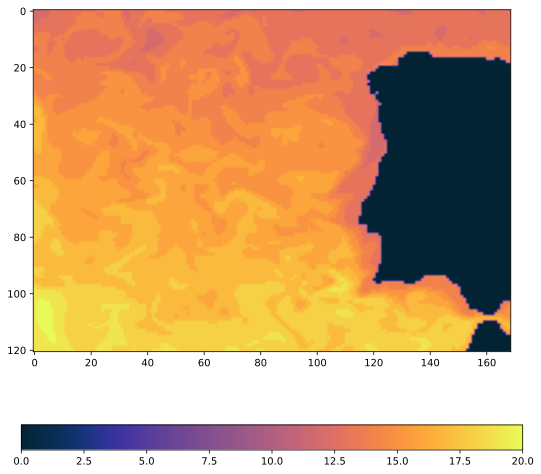

In [131]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
import cmocean
im = plt.imshow(Temp_aux, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = (9,9)
plt.colorbar(im, orientation='horizontal')
plt.show()

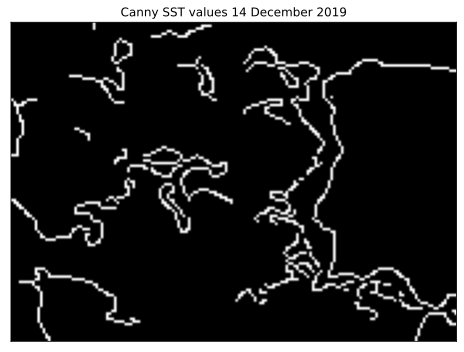

In [55]:
canny = cv2.Canny(Temp_aux, 3.75, 7.5, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny, 'gray')    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values 14 December 2019')
plt.xticks([])
plt.yticks([])
    
plt.show()

#Canny aplicado ao numpy array

#### --------------------------------------------------------------------------------------------------------------
#### Usar um array com formato uint8, com valores entre 0 e 255 (MAIS CORRETO)
#### --------------------------------------------------------------------------------------------------------------

In [56]:
# Matriz de temperatura em que os valores estão entre 0 e 255
Temp_aux5 = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')
Temp_aux5

array([[234, 233, 233, ...,   0,   0,   0],
       [236, 236, 236, ...,   0,   0,   0],
       [238, 238, 237, ...,   0,   0,   0],
       ...,
       [ 23,  25,  25, ...,  56,  55,  47],
       [ 19,  20,  19, ...,  53,  51,  46],
       [ 20,  18,  17, ...,  49,  50,  50]], dtype=uint8)

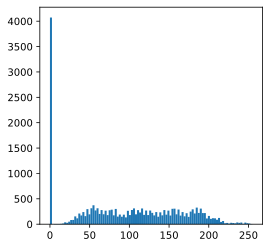

In [58]:
#Para verificarmos que os valores estão de facto entre 0 e 255
plt.hist(Temp_aux5.flatten(), bins=100);
plt.rcParams["figure.figsize"] = 4, 4

In [59]:
Temp_aux5 = np.flipud(Temp_aux5)   #flipud -> Reverse the order of elements along axis 0 (up/down).
Temp_aux5

array([[ 20,  18,  17, ...,  49,  50,  50],
       [ 19,  20,  19, ...,  53,  51,  46],
       [ 23,  25,  25, ...,  56,  55,  47],
       ...,
       [238, 238, 237, ...,   0,   0,   0],
       [236, 236, 236, ...,   0,   0,   0],
       [234, 233, 233, ...,   0,   0,   0]], dtype=uint8)

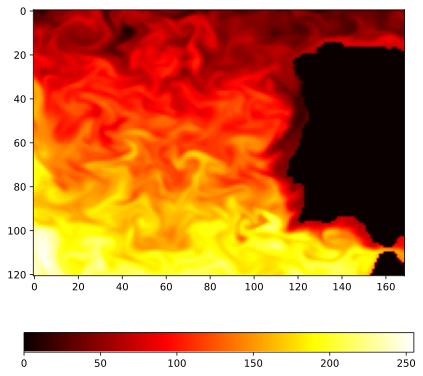

In [61]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
im3 = plt.imshow(Temp_aux5, cmap='hot')
plt.rcParams["figure.figsize"] = (7,7)
plt.colorbar(im3, orientation='horizontal')
plt.show()

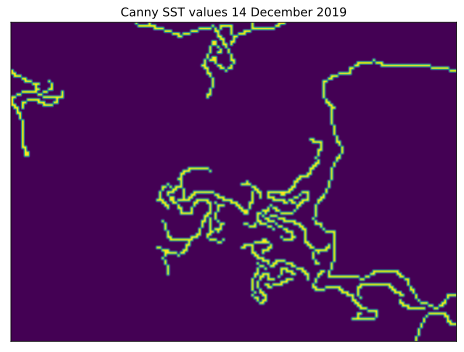

In [62]:
canny3 = cv2.Canny(Temp_aux5, 10, 250, L2gradient=False, apertureSize=3)

plt.rcParams["figure.figsize"] = (8,8)

plt.imshow(canny3)    #'gray'-> parametro para por a preto e branco
plt.title('Canny SST values 14 December 2019')
plt.xticks([])
plt.yticks([])
    
plt.show()

### Para Interpretação

/tmp/ipykernel_7362/697545229.py:36: UserWarning: No contour levels were found within the data range.
  cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)


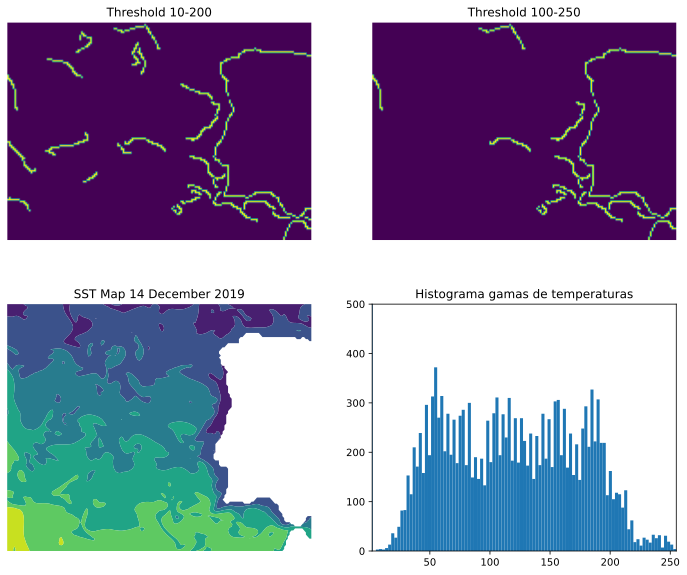

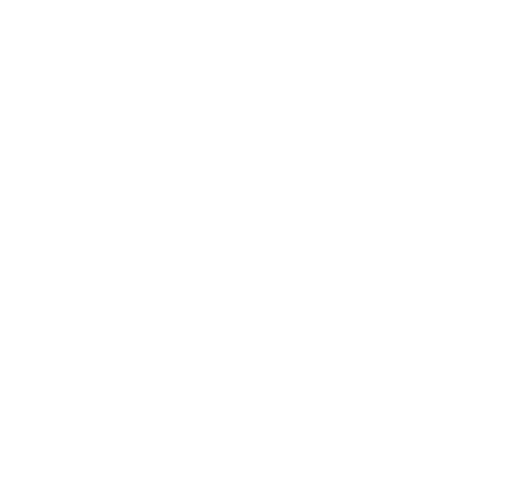

In [133]:
# create figure
fig = plt.figure(figsize=(12, 10))

# setting values to rows and column variables
rows = 2
columns = 2

#apertureSize -> Order of Kernel(matrix) for the Sobel filter. Default value is (3 x 3). value should be odd between 3 and 7
#L2gradient -> specifies the equation for finding gradient magnitude. L2gradient is of boolean type. Its default value is False

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
#Definição dos parametros do canny
canny_1 = cv2.Canny(Temp_aux5, 10, 200, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_1)
plt.axis('off')
plt.title("Threshold 10-200");

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
#Definição dos parametros do canny
canny_2 = cv2.Canny(Temp_aux5, 100, 250, L2gradient=False, apertureSize=3)
# showing image
plt.imshow(canny_2)
plt.axis('off')
plt.title("Threshold 100-250");


# Adds a subplot to show the image

ax = fig.add_subplot(rows, columns, 3)
# Generate a color mapping of the levels we've specified
cpf = ax.contourf(X,Y,Temp, len(levels), cmap=cm.viridis)
# Make plot and customize axes
cp = ax.contour(X, Y, Temp,  levels=levels, colors=line_colors)
ax.clabel(cp, fontsize=10, colors=line_colors);
plt.axis('off');       #Para remover da imagem os labels com a longitude e latitude
plt.title('SST Map 14 December 2019');


# Adds a subplot at tshow um histograma com a dispersão dos valores de temperatura na matriz da imagem
fig.add_subplot(rows, columns, 4)
#Definição dos parametros do canny
histograma = plt.hist(Temp_aux5.flatten(), bins=100);
plt.xlim([2, 255])
plt.ylim([0, 500])
# showing image
plt.title("Histograma gamas de temperaturas");
plt.show(histograma);
plt.axis('off');

    
#plt.show()